# 导入函数处理模块
具体的库主要有**绘图库**、**神经网络模块库**、**计算机视觉库**、**基本库**等

In [1]:
# division的作用就是可以 3/4 = 0.75 而不是 0
from __future__ import print_function,division

# 导入神经网络模块
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# 导入 pytorch 的计算机视觉模块
import torchvision
from torch.utils.data import DataLoader as DataLoader
from torchvision import datasets, models, transforms

# 导入基本库
import os
import time
import copy

# 导入数据分析与matplotlib绘图库
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 打开交互模式，可以看到动态过程
plt.ion()

# 图像预处理
预处理的操作有：\\
`随机裁剪成某个固定大小的正方形`，\\
`随机翻转和旋转图片`，\\
`图片转化成张量`，\\
`对张量正则化处理`；\\
同时，对于val集，我们不对其做增强操作，我们仅对其做:\\
`缩放图片`\\
`裁剪成和训练集一样大小的图片`\\
`转化张量`\\
`张量正则化处理`\\

In [2]:
# 对train集进行 数据增强 和 数据正则化
# 仅valid集进行 数据正则化
# 用transforms.Compose将一系列的transforms方法进行有序的组合包装，用包装的方法制作图像预处理样式

data_transforms = {
    'train': transforms.Compose([
        # 随机大小裁剪图片，得到 224 * 224 大小的图片
        transforms.RandomResizedCrop(224),  
        # 随机图片翻转和旋转
        transforms.RandomHorizontalFlip(),
        # 将图片转化成张量
        transforms.ToTensor(),
        # 张量正则化处理
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),

    'val': transforms.Compose([
        # 改变图像大小，得到的是 xxx * 256 的！
        transforms.Resize(256),
        # 图片中心裁剪,得到 224*224的图片
        transforms.CenterCrop(224),
        # 将图片转化成张量
        transforms.ToTensor(),
        # 张量正则化处理
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

# 导入图片的操作

In [3]:
# 根目录的地址 
# Kaggle中是: '/kaggle/input/titlename'
data_dir = './leaf_dataset'
# 图片的数据集字典，使用 datasets.ImageFolder 构建图片数据集
# 对图片的数据集进行预处理，要求按类别进行处理
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train','val']}

# 数据集加载，要求按照类别进行加载，每4个图片为1个批次，加载的线程数为4线程
dataloaders = {x: DataLoader(image_datasets[x], 
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train','val']}

# 设置好设备，一般需要判断是否使用GPU或CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''''''''''''''''''''''''''''''''''''''''''''
下面的两个数据
是用来今后做统计的
并不是空穴来风!
'''''''''''''''''''''''''''''''''''''''''''''

# 数据集大小，按类别进行分类                          
# {'train': 64, 'val': 16}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

# 训练集内的类别名字，只有train和val类别之分          
# ['Minor', 'bees']；
class_names = image_datasets['train'].classes

# 写一个展示图片的函数

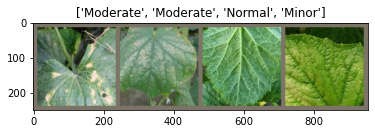

In [4]:
def imshow(inp, title=None):
    # 于 plt.imshow() 实际输入的是(imagesize,imagesize,channels),
    # 而 def imshow() 中，参数img的格式为(channels,imagesize,imagesize),
    # 这两者的格式不一致，我们需要调用一次 np.transpose 函数，即 np.transpose(npimg,(1,2,0))
    # 将 npimg 的数据格式由（channels,imagesize,imagesize）转化为（imagesize,imagesize,channels）
    # 把 0，1，2 转换成 1，2，0
    inp = inp.numpy().transpose((1,2,0))
    
    # 使用 ImageNet 训练数百万次得到 平均值 和 标准差
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    # x = (x-mean)/std 
    inp = std * inp + mean
    
    # np.clip(a, a_min, a_max, out)
    # a为输入数组。a_min为限定的最小值，a_max为限定的最大值，这两个都可以是数组，但是shape得跟a一样
    inp = np.clip(inp, 0, 1)
    
    # 展示图片
    plt.imshow(inp)
    
    # 如果title被定义，那么久按照定义的title显示
    if title is not None:
        plt.title(title)
    
    # 如果当前有活动的图形，在pause函数运行前，图形将会更新并显示，在等待期间事件循环会一直运行，直到暂停时间0.001秒后结束
    plt.pause(0.001)

# 迭代训练集，得到训练集的输入值和类型，类型为整数
# next(iter())这是一起用的，因为dataloader设置了每4展示
inputs, classes = next(iter(dataloaders['train']))

# 输出图像，用图像做一个‘网格图’
out = torchvision.utils.make_grid(inputs, padding=12)

# classes 的结果是 tensor([1, 1, 0, 1]); 与index相同
# class_names=['ants', 'bees']  
# class_names[0]='ants'; class_names[1]='bees'
imshow(out, title=[class_names[x] for x in classes])

# 训练模型的函数
涉及到**模型**、**优化器**、**迭代数**

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    # time.time()返回1970纪元后的秒数浮点数
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                # 启用 Batch Normalization 和 Dropout
                # 保证BN层能够用到每一批数据的均值和方差
                model.train()
            else:
                # 不启用 Batch Normalization 和 Dropout。
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 参数梯度的手动归零
                optimizer.zero_grad()
                
                # 前向传播
                # set_grad_enabled == TRUE 时，保证接下来的tensor都是可以求导的
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # torch.max() 返回两个值，1是dim=1的简写，输出所在‘行’的最大值
                    # 第一个是value；第二个是value所在的index，也就是preds
                    # _表示具体的value，也就是最大值
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 迁移？
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.
          format(time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0 
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
                
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_fits = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_fits, 4)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma=0.1)

In [8]:
#model_ft = train_model(model_ft, criterion, optimizer_ft, 
                       #exp_lr_scheduler, num_epochs=25)

In [9]:
#visualize_model(model_ft)

In [10]:
# ConvNet 固定特征提取器 
# 卷积模型选择18层残差网络
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 输入的特征数
num_fits = model_conv.fc.in_features
model_conv.fc = nn.Linear(512, 4)
model_conv = model_conv.to(device)

# loss计算
criterion = nn.CrossEntropyLoss()

# 卷积优化方法随机梯度下降
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 学习率指数
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv,
                         criterion,
                         optimizer_conv,
                         exp_lr_scheduler,
                         num_epochs=25)

Epoch 1/25
----------
train Loss: 1.6825 Acc: 0.2812
val Loss: 1.6952 Acc: 0.1875

Epoch 2/25
----------
train Loss: 1.4692 Acc: 0.3281
val Loss: 1.5624 Acc: 0.2500

Epoch 3/25
----------
train Loss: 1.3106 Acc: 0.4375
val Loss: 1.3144 Acc: 0.4375

Epoch 4/25
----------
train Loss: 1.2660 Acc: 0.3906
val Loss: 1.4142 Acc: 0.4375

Epoch 5/25
----------
train Loss: 1.2678 Acc: 0.4062
val Loss: 1.3078 Acc: 0.3750

Epoch 6/25
----------
train Loss: 1.0171 Acc: 0.5938
val Loss: 1.1756 Acc: 0.4375

Epoch 7/25
----------
train Loss: 1.0205 Acc: 0.5938
val Loss: 1.4777 Acc: 0.4375

Epoch 8/25
----------
train Loss: 0.9865 Acc: 0.5625
val Loss: 1.2475 Acc: 0.3750

Epoch 9/25
----------
train Loss: 0.9513 Acc: 0.6562
val Loss: 1.1531 Acc: 0.3750

Epoch 10/25
----------
train Loss: 0.8799 Acc: 0.6719
val Loss: 1.1902 Acc: 0.4375

Epoch 11/25
----------
train Loss: 1.0636 Acc: 0.6094
val Loss: 1.2052 Acc: 0.4375

Epoch 12/25
----------
train Loss: 0.7985 Acc: 0.7500
val Loss: 1.1671 Acc: 0.4375

E

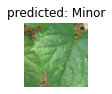

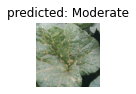

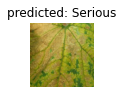

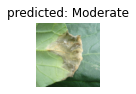

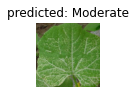

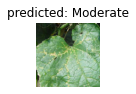

In [12]:
visualize_model(model_conv)
plt.ioff()
plt.show()